# Evaluate models to get error metrics

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from math import sqrt
from baumhofer_utils import *

from ml_utils import models, tools

from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from IPython.display import clear_output

### Load the data from file

In [63]:
# Load the data we will need
with open("./data/X_array_first_100.pkl", "rb") as a_file:
    X = pickle.load(a_file)
# Reshape the data
X = reshape_for_model(X, to_plot=False)

with open("./data/index_first_100.pkl", "rb") as a_file:
    index = pickle.load(a_file)

with open("./data/y_array_first_100.pkl", "rb") as a_file:
    y = pickle.load(a_file)

# Change the path for this one so it points to your local copy - too big for GitHub
# with open("E:/new_german_data/code/processed_data/baumhofer_first_100_cycles.pkl", "rb") as a_file:
#     data = pickle.load(a_file)

cells = list(data.keys())
index_cells = np.array([name.split("_")[0] for name in index])
    
del a_file

### Define some functions

In [68]:
def train_nn_model(X, y, model, batch_size=512, epochs=200, callback=True):
    
    if callback:        
        callbacks = [LearningRateScheduler(tools.lr_scheduler, verbose=0)]
    else:
        callbacks = []
    
    model.fit(X,y,
              batch_size=batch_size,
              epochs=epochs,    
              shuffle=True,
              callbacks=callbacks,
              verbose=0)
    
    return model


def calc_evaluation_metrics(model, X_train, y_train, X_test, y_test):
    mape_train = model.evaluate(X_train, y_train)[1]
    mape_test = model.evaluate(X_test, y_test)[1]
    
    rmse_train =  sqrt(mean_squared_error(y_train, model.predict(X_train).flatten()))
    rmse_test =  sqrt(mean_squared_error(y_test, model.predict(X_test).flatten()))
    
    return mape_train, mape_test, rmse_train, rmse_test


def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    
    # Create model instance explicitly
    model = models.build_convnet_model(X_in=X_train, loss='mse', n_outputs=1)
    train_nn_model(X_train, y_train, model, batch_size=512, epochs=5, callback=True)

    metrics = calc_evaluation_metrics(model, X_train, y_train, X_test, y_test)
    print(metrics)
    clear_output() # remove this if you want loads of stuff printed out
    
    return model, metrics


def print_metrics(model_dict, data_type, target_name):
    
    if data_type.lower() == "capacity" or data_type.upper() == "IR":
        train_scores = np.array(model_dict[data_type][target_name]['train_scores'])
        test_scores = np.array(model_dict[data_type][target_name]['test_scores'])
        
        mean_train_MAPE, mean_train_RMSE = np.mean(train_scores, axis=0)
        mean_test_MAPE, mean_test_RMSE = np.mean(test_scores, axis=0)
        
        print(f"Average evaluation metrics for {data_type} target: {target_name}")
        print("---------------------------------------------")
        print(f"Mean train RMSE: \t{mean_train_RMSE:.2f}")
        print(f"Mean test RMSE: \t{mean_test_RMSE:.2f}")
        print(f"Mean train MAPE: \t{mean_train_MAPE:.2f}%")
        print(f"Mean test MAPE: \t{mean_test_MAPE:.2f}%")

### Train/Test Split and Scaling
Notice that we don't have IR data for cell 030. This will need to be handled later.

In [69]:
train_cells, test_cells = train_test_split(cells, train_size=0.9, random_state=31)
train_cells, test_cells = np.array(train_cells), np.array(test_cells)

index_train = np.in1d(index_cells, train_cells)
index_test = np.in1d(index_cells, test_cells)

X_train, X_test = X[index_train], X[index_test]
y_train, y_test = y[index_train], y[index_test]

# Scaling
X_train, _, X_test = scaler_3d(X_train,
                                 X_test,
                                 X_test,
                                 scaler_type='robust',
                                 return_scaler=False)

### Compute train/test scores
___

This is done for each training target to calculate evaluation metrics for the paper.

In [70]:
# Create a dictionary structure to store the trained models and scores
data_types = ['capacity', 'IR']
targets = ['tto', 'ttp', 'tte', 'deg_o', 'deg_p']

model_dict = {var:
              {target:
               {'models': [], 'train_scores': [], 'test_scores': []}
               for target in targets}
              for var in data_types}

del data_types

In [72]:
# Specify the number of times to train and evaluate each model
n_iterations = 3 # set to 3 for speed during development

for target_idx, target_name in enumerate(targets): # define how many targets you want to examine
    for i in range(n_iterations):
        print(f"Running for target index {target_idx}: {target_name}")
        print(f"Iteration {i+1}")
        model, metrics = train_and_evaluate_model(X_train, y_train[:, target_idx], 
                                                  X_test, y_test[:, target_idx])

        # Split the metrics into individual variables
        train_MAPE, test_MAPE, train_RMSE, test_RMSE = metrics

        # Store the trained models and scores in the dictionary
        model_dict['capacity'][target_name]['models'] = model
        model_dict['capacity'][target_name]['train_scores'].append([train_MAPE, train_RMSE])
        model_dict['capacity'][target_name]['test_scores'].append([test_MAPE, test_RMSE])

In [61]:
# Print the average evaluation metrics for train and test,
# for the specified data type (capacity/IR) and target (tto, ttp, tte, deg_o, deg_p)
print_metrics(model_dict, data_type='capacity', target_name='ttp')

Average evaluation metrics for capacity target: ttp
---------------------------------------------
Mean train RMSE: 	1081.46
Mean test RMSE: 	1083.83
Mean train MAPE: 	100.00%
Mean test MAPE: 	100.00%


### @ Calum -- we don't have the calaculate_CI function

In [36]:
mean_train_MAPE, mean_test_MAPE, mean_train_RMSE, mean_test_RMSE = np.mean(evaluation_metrics, axis=0)
var_train_MAPE, var_test_MAPE, var_train_RMSE, var_test_RMSE = np.var(evaluation_metrics, axis=0)

print('')
print('>>    Average evaluation metrics')
print('')

print('       --------------------------------')
print('      | Mean train RMSE | %s +-  %s |' % (float('%.2g'% mean_train_RMSE), float('%.4g'% calculate_CI(mean_train_RMSE, var_train_RMSE))))
print('       --------------------------------')
print('      | Mean test RMSE  | %s +- %s |' % (float('%.2g'% mean_test_RMSE), float('%.4g'% calculate_CI(mean_test_RMSE, var_test_RMSE))))
print('       --------------------------------')
print('      | Mean train MAPE |  %s +- %s |' % (float('%.2g'% mean_train_MAPE), float('%.4g'% calculate_CI(mean_train_MAPE, var_train_MAPE))))
print('       --------------------------------')
print('      | Mean test MAPE  |  %s +- %s |' % (float('%.2g'% mean_test_MAPE), float('%.4g'% calculate_CI(mean_test_MAPE, var_test_MAPE))))
print('       --------------------------------')


>>    Average evaluation metrics for RUL

       --------------------------------
      | Mean train RMSE | 55.0 +-  5.774 |
       --------------------------------
      | Mean test RMSE  | 110.0 +- 24.41 |
       --------------------------------
      | Mean train MAPE |  3.8 +- 0.3711 |
       --------------------------------
      | Mean test MAPE  |  9.5 +- 1.56 |
       --------------------------------


Calculate MAE

In [37]:
MAEs_train_RUL = []
MAEs_test_RUL = []

for model in trained_models_RUL:
    MAEs_train_RUL.append(np.mean(np.abs(model.predict(X_train_RUL_sc).flatten() - y_train_RUL)))
    MAEs_test_RUL.append(np.mean(np.abs(model.predict(X_test_RUL_sc).flatten() - y_test_RUL)))

In [38]:
    
print('       --------------------------------')
print('      | Mean train MAE | %s +-  %s |' % (float('%.2g'% np.mean(MAEs_train_RUL)), float('%.4g'% calculate_CI(np.mean(MAEs_train_RUL), np.var(MAEs_train_RUL)))))
print('       --------------------------------')
print('      | Mean test MAE  | %s +- %s |' % (float('%.2g'% np.mean(MAEs_test_RUL)), float('%.4g'% calculate_CI(np.mean(MAEs_test_RUL), np.var(MAEs_test_RUL)))))
print('       --------------------------------')

       --------------------------------
      | Mean train MAE | 33.0 +-  3.356 |
       --------------------------------
      | Mean test MAE  | 73.0 +- 12.35 |
       --------------------------------


# Dropout models
___

This code should be used on the full models to predict the full curve 

In [ ]:
# This is a variant of the function from the blog post. It returns a model
# instead of a Keras function

def create_dropout_predict_model(model, dropout):
    """
    Create a keras function to predict with dropout
    model : keras model
    dropout : fraction dropout to apply to all layers

    Returns
    predict_with_dropout : instance of a model for predicting with dropout
    """

    # Load the config of the original model
    conf = model.get_config()
    # Add the specified dropout to all layers
    for layer in conf['layers']:
      # Dropout layers
        if layer["class_name"]=="Dropout":
            layer["config"]["rate"] = dropout
      # Recurrent layers with dropout
        elif "dropout" in layer["config"].keys():
            layer["config"]["dropout"] = dropout

    # Create a new model with specified dropout
    if type(model)==Sequential:
      # Sequential
        model_dropout = Sequential.from_config(conf)
    else:
      # Functional
        model_dropout = Model.from_config(conf)

    model_dropout.set_weights(model.get_weights()) 

    # Create an instance of a model 
    predict_with_dropout = Model(model_dropout.inputs, model_dropout.outputs)

    return predict_with_dropout

In [173]:
'''
PROCEDURE:

generate predictions using the trained model and compute the residuals

for each dropout rate
  * create an instance of a model with that rate
  * generate num_iter predictions using that model
  * subtract the median of those dropout predictions from the dropout predictions array - generating "dropout_prediction_distribution" variable
    (this will be used to determine the percentage of values that fall within the limits for a confidence level)

  for each confidence level
    * compute the lower and upper limits based on the dropout predictions array, using np.quantile()
    * store the results in a dictionary whose keys are the confidence levels

  calculate the percentage of ground truth values that fall between the lower and upper limit for each confidence level
'''


n_outputs=6

# Set up necessary arrays to store parameters and results
dropout_rates = np.arange(0.1,0.7, 0.05)
conf_levels = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
# The rows of results_array will contain the percentages for each dropout rate
results_array = np.empty(shape=(n_outputs, len(dropout_rates), len(conf_levels)))

num_iter = 100
#dropout_predictions = np.zeros((X_test.shape[0], num_iter))
dropout_predictions = np.zeros((num_iter, y_test.shape[0], y_test.shape[1]))

# Make a prediction on the validation data (called test here) using the model
predictions = val_full_IR_model.predict(X_test)

# Calculate the difference between the predictions and the actual values
residuals = predictions.squeeze() - y_test

In [ ]:
plt.plot(residuals)

In [ ]:
# For each dropout rate, create an instance of a model with dropout used during inference
for j in range(dropout_rates.shape[0]):
    #print(f"Executing dropout rate {dropout_rates[j]}")
    model_with_dropout = create_dropout_predict_model(val_full_IR_model, dropout_rates[j])

    # Get the predictions from the model with dropout, having been run num_iter times
    for i in range(num_iter):
    #if i%10==0:
      #print(f"\tExecuting prediction iteration {i}")
        d_prediction = np.array(model_with_dropout([X_test], training=True))
        #dropout_predictions[:,i] = d_prediction
        dropout_predictions[i,:] = d_prediction

    dropout_prediction_distribution = dropout_predictions - np.median(dropout_predictions, axis=0)
    
    for i in range(0,n_outputs):
            

        # Instantiate a dictionary and store the lower and upper limits for each
        # confidence level as an array
        confidence_intervals = dict.fromkeys(conf_levels)

        for key in confidence_intervals.keys():
            confidence_intervals[key] = np.array([np.quantile(dropout_prediction_distribution[:,:,i], 0.5-key/2), np.quantile(dropout_prediction_distribution[:,:,i], 0.5+key/2)])

        # Calculate the percentage of ground truth values fall between the lower and upper limit for each confidence level
        results = []
        for level in conf_levels:
            #print(f"\t\tCalculating percentages for confidence level {level*100}%")
            lower_lim = confidence_intervals[level][0]
            upper_lim = confidence_intervals[level][1]

            num_in_range = np.sum(np.array((residuals[:,i].flatten() > lower_lim) & (residuals[:,i].flatten() < upper_lim)).astype(int))
            pct_in_range = (num_in_range / len(residuals[:,i].flatten()))
            #print(pct_in_range)
            results.append(pct_in_range)

        results_array[i, j,:] = np.array([results])

In [ ]:
titles = ['IR elbow_o', 'IR elbow', 'IR EOL', 'elbow_o', 'elbow', 'EOL']

for i in range(0,n_outputs):
    # Plotting
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    for j in range(len(dropout_rates)):
          plt.plot(conf_levels, results_array[i,j,:])
    ax.set_aspect('equal', adjustable='box')
    plt.plot([[0,0], [1,1]], 'k')
    plt.legend([f"Dropout = {rate}" for rate in dropout_rates])
    plt.title(titles[i])
    plt.show()

# An example of predicting the full curve
___


Now that we have decided on the dropout rates, let's do the joint prediction.

In the below we should place the selected dropout rates and the relevant models.

The prediction was done with
* one model to predict *'time to'*: ttk-o, ttk-p, RUL, tte-o and tte-p
* one model to predict *'capacity at'*: Q@k-o and Q@k-p
* one model to predict *'IR at'*: IR@e-o, IR@e-p and IR@EOL

In [63]:
# tt models
model_knee_o = create_dropout_predict_model(one_model_to_predict_tt, 0.45)
model_knee_p = create_dropout_predict_model(one_model_to_predict_tt, 0.325)
model_elbow_o = create_dropout_predict_model(one_model_to_predict_tt, 0.35)
model_elbow_p = create_dropout_predict_model(one_model_to_predict_tt, 0.30)
model_RUL = create_dropout_predict_model(one_model_to_predict_tt, 0.35)

# Capcity models
model_Q_at_knee_p = create_dropout_predict_model(one_model_to_predict_Q, 0.15)
model_Q_at_knee_o = create_dropout_predict_model(one_model_to_predict_Q, 0.3)

# IR models
model_IR_at_elbow_o = create_dropout_predict_model(one_model_to_predict_IR, 0.75)
model_IR_at_elbow_p = create_dropout_predict_model(one_model_to_predict_IR, 0.7)
model_IR_at_EOL = create_dropout_predict_model(one_model_to_predict_IR, 0.5)


In [64]:
def predict_full_curves_3_models(x, current_Q, current_IR, cycle):
    curve_Q = np.zeros(shape=(len(x), 4, 2))
    curve_IR = np.zeros(shape=(len(x), 4, 2))
     
    # tt predictions 
    pred_ttko = model_knee_o(x, training=True)[:,0]
    pred_ttkp = model_knee_p(x, training=True)[:,1]
    pred_tteo = model_elbow_o(x, training=True)[:,2]
    pred_ttep = model_elbow_p(x, training=True)[:,3]
    pred_RUL = model_RUL(x, training=True)[:,4]
    
    # capacity predictions
    pred_Q_at_knee_p = current_Q - model_Q_at_knee_p(x, training=True)[:,0]/10000
    pred_Q_at_knee_o = current_Q - model_Q_at_knee_o(x, training=True)[:,1]/10000
    
    # IR predictions
    pred_IR_at_elbow_o = model_IR_at_elbow_o(x, training=True)[:,0]/2000000 + current_IR
    pred_IR_at_elbow_p = model_IR_at_elbow_p(x, training=True)[:,1]/2000000 + current_IR
    pred_IR_at_EOL = model_IR_at_EOL(x, training=True)[:,2]/2000000 + current_IR
    
    for i in range(len(x)):
        # now we encode these points in 2D
        curve_IR[i] = [[cycle, np.array([current_IR])[i]],
                 [pred_tteo[i] + cycle, pred_IR_at_elbow_o[i]],
                 [pred_ttep[i] + cycle, pred_IR_at_elbow_p[i]],
                 [pred_RUL[i] + cycle, pred_IR_at_EOL[i]]        
                ]
        
        curve_Q[i] = [[cycle, np.array([current_Q])[i]],
                 [pred_ttko[i] + cycle, pred_Q_at_knee_o[i]],
                 [pred_ttkp[i] + cycle, pred_Q_at_knee_p[i]],
                 [pred_RUL[i] + cycle, 0.88]        
                ]
    return curve_Q, curve_IR
    

this code interpolates between the predictions and the confidence intervals to produce full curve PI

In [ ]:
def plot_full_curve_PI(mean_x, mean_y, axes, color_95='deepskyblue',color_80='grey', alpha_95=0.2, alpha_80=0.5, up_or_down='down'):
    # prediction interval for whole curve
        ## 95% PI
        
    
    
    f_y = interpolate.interp1d(mean_y, CI_95_y/[1,1.5,1.5,100000], fill_value="extrapolate")
    f_x = interpolate.interp1d(mean_x, CI_95_x/[1,1.5,1.5,1], fill_value="extrapolate")
        
    ynew = np.linspace(mean_y[1], mean_y[-1], len(y_interp))
    xnew = np.linspace(mean_x[1], mean_x[-1], len(y_interp))

    CInew_y = f_y(ynew)
    CInew_x = f_x(xnew)

    
    
    if up_or_down =='down':
        upper_curve = np.array([np.arange(mean_x[1],mean_x[-1])+CInew_x,y_interp+CInew_y])
        lower_curve = np.array([np.arange(mean_x[1],mean_x[-1])-CInew_x,y_interp-CInew_y])
    else:
        upper_curve = np.array([np.arange(mean_x[1],mean_x[-1])-CInew_x,y_interp+CInew_y])
        lower_curve = np.array([np.arange(mean_x[1],mean_x[-1])+CInew_x,y_interp-CInew_y])
     
    ynew = np.linspace(mean_y[0], mean_y[1], len(np.arange(mean_x[0],mean_x[2])))
    xnew = np.linspace(mean_x[0], mean_x[1], len(np.arange(mean_x[0],mean_x[2])))

    CInew_y = f_y(ynew)
    CInew_x = f_x(xnew) 
    
    
    if up_or_down =='down':        
        upper_line = np.array([xnew+CInew_x, ynew+CInew_y])
        lower_line = np.array([xnew-CInew_x, ynew-CInew_y])       
    else:
        upper_line = np.array([xnew-CInew_x, ynew+CInew_y])     
        lower_line = np.array([xnew+CInew_x, ynew-CInew_y])

        
        
    upper = np.hstack([upper_line, upper_curve])
    lower = np.hstack([lower_line, lower_curve])
    


    f_upper = interpolate.interp1d(upper[1], upper[0], fill_value="extrapolate")
    f_lower = interpolate.interp1d(lower[1], lower[0], fill_value="extrapolate")
        
    # y from initial to end

    y_cover = np.linspace(mean_y[0],mean_y[-1], 1000)

    

    axes.fill_betweenx(y_cover, f_lower(y_cover), f_upper(y_cover), color=color_95, alpha=alpha_95,zorder=1)
    
    

        ## 80% PI

    f_y = interpolate.interp1d(mean_y, CI_80_y/[1,1.5,1.5,100000], fill_value="extrapolate")
    f_x = interpolate.interp1d(mean_x, CI_80_x/[1,1.5,1.5,1], fill_value="extrapolate")

    ynew = np.linspace(mean_y[1], mean_y[-1], len(y_interp))
    xnew = np.linspace(mean_x[1], mean_x[-1], len(y_interp))


    CInew_y = f_y(ynew)
    CInew_x = f_x(xnew)

    if up_or_down =='down':
        upper_curve = np.array([np.arange(mean_x[1],mean_x[-1])+CInew_x,y_interp+CInew_y])
        lower_curve = np.array([np.arange(mean_x[1],mean_x[-1])-CInew_x,y_interp-CInew_y])
    else:
        upper_curve = np.array([np.arange(mean_x[1],mean_x[-1])-CInew_x,y_interp+CInew_y])
        lower_curve = np.array([np.arange(mean_x[1],mean_x[-1])+CInew_x,y_interp-CInew_y])



    ynew = np.linspace(mean_y[0], mean_y[1], len(np.arange(mean_x[0],mean_x[2])))
    xnew = np.linspace(mean_x[0], mean_x[1], len(np.arange(mean_x[0],mean_x[2])))

    CInew_y = f_y(ynew)
    CInew_x = f_x(xnew) 

    if up_or_down =='down':        
        upper_line = np.array([xnew+CInew_x, ynew+CInew_y])
        lower_line = np.array([xnew-CInew_x, ynew-CInew_y])       
    else:
        upper_line = np.array([xnew-CInew_x, ynew+CInew_y])  
        lower_line = np.array([xnew+CInew_x, ynew-CInew_y])
       

    upper = np.hstack([upper_line, upper_curve])
    lower = np.hstack([lower_line, lower_curve])

    # converting to lines interms of y

    f_upper = interpolate.interp1d(upper[1], upper[0], fill_value="extrapolate")
    f_lower = interpolate.interp1d(lower[1], lower[0], fill_value="extrapolate")
    
    
    
    # y from initial to end
    y_cover = np.linspace(mean_y[0],mean_y[-1], 1000)
    
    axes.fill_betweenx(y_cover, f_lower(y_cover), f_upper(y_cover), color=color_80, alpha=alpha_80, zorder=1)


        

 ## Here are the plots 

In [43]:
cells_to_plot = np.array(['b1c4', 'b1c7', 'b2c14', 'b2c30', 'b2c45','b3c9', 'b3c26', 'b3c34', 'b8c20'], dtype='<U5')

In [69]:
np.random.randint(1,10, 9)

array([2, 6, 2, 2, 5, 2, 8, 5, 1])

In [44]:
cycles_to_plot = np.array([2, 6, 2, 2, 5, 2, 8, 1, 5])

In [45]:
from scipy import interpolate

In [46]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

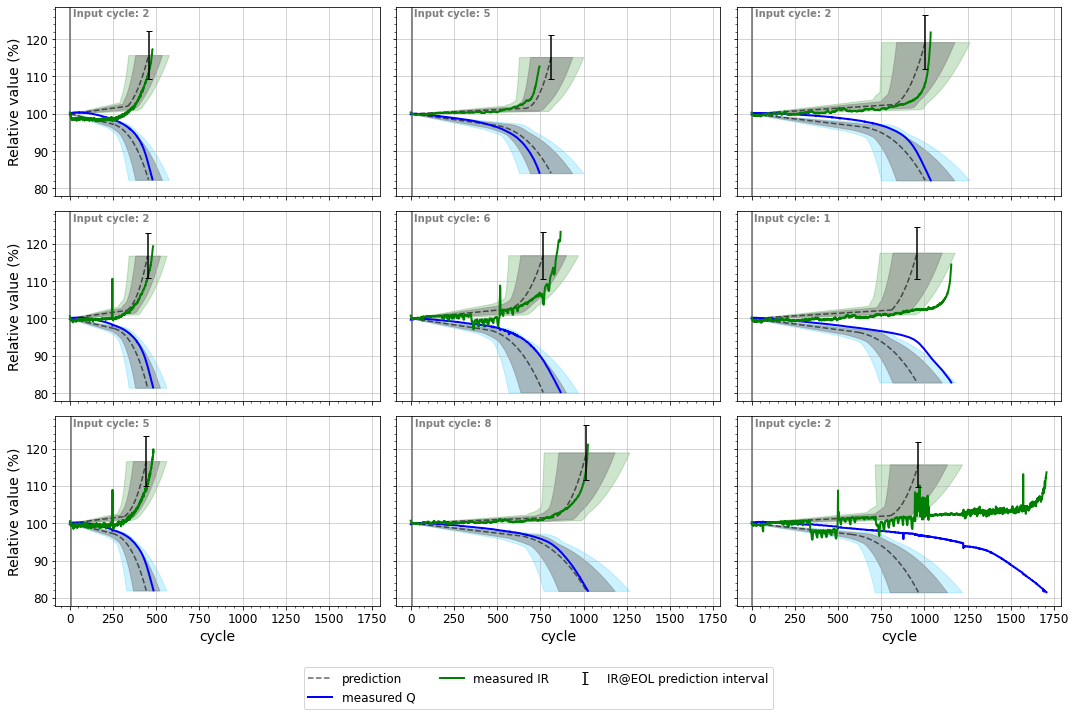

In [72]:
j = 0
n_bootstrap_predictions = 100


fig, ax = plt.subplots(3,3, figsize=(15,10), edgecolor='yellow', sharex=True, sharey=True)

cells_plotted = 0



for i in range(len(X_test_RUL_sc)):
    
    
    if i == 0 or i%n_cycles == 0:
        cell = list_test_cells[j]
        j += 1
        cycle = 0
    
    
    
   
    if cell == 'b2c30':
        l = 0
        m = 0
    if cell == 'b2c45':
        l = 0
        m = 1
    if cell == 'b8c20':
        l = 1
        m = 0
    if cell == 'b2c45':
        l=2
        m=0
    if cell =='b3c9':
        l=0
        m=2        
    if cell == 'b1c7':
        l=1
        m=1        
    if cell == 'b3c34':
        l=1
        m=2       
    if cell == 'b3c26':
        l=2
        m=1
        
    
    
   
    if cells_plotted==len(cells_to_plot):
        continue
    
    if  cell == cells_to_plot[cells_plotted] and cycle==cycles_to_plot[cells_plotted]:
        
    

        if cell == 'b1c4':
            l = 2
            m = 2
        if cell == 'b2c30':
            l = 0
            m = 0
        if cell == 'b8c20':
            l = 0
            m = 1
        if cell == 'b2c14':
            l = 1
            m = 0
        if cell == 'b2c45':
            l=2
            m=0
        if cell =='b3c9':
            l=0
            m=2        
        if cell == 'b1c7':
            l=1
            m=1        
        if cell == 'b3c34':
            l=1
            m=2       
        if cell == 'b3c26':
            l=2
            m=1

        
        
        full_Q = data_dict[cell]['summary']['QDischarge']
        true_Q = full_Q.copy()
        
        full_Q = full_Q[full_Q>0.88]
        current_Q = full_Q[cycle]
        
        if 'b8' in cell: 
            full_IR = b8_IR[cell][0]
        else:
            full_IR = data_dict[cell]['summary']['IR'] 
        
        # fix missing values
        for k, ir in enumerate(full_IR):
            if ir == 0:
                full_IR[k] = (full_IR[k+10] + full_IR[k+5] + full_IR[k+2])/3
        if len(full_IR) > len(full_Q):
            full_IR = full_IR[true_Q >0.88]
        current_IR = full_IR[cycle]
    
    
        
        Q_x_predictions = []
        Q_y_predictions = []
        
        IR_x_predictions = []
        IR_y_predictions = []
        
        
        for k in range(n_bootstrap_predictions):
            pred_Q_curve, pred_IR_curve = predict_full_curves_3_models(X_test_RUL_sc[i:i+1], np.array(current_Q), np.array(current_IR), cycle)
        
            Q_x_predictions.append(pred_Q_curve[0][:,0])
            Q_y_predictions.append(100*pred_Q_curve[0][:,1]/current_Q)  
            
            IR_x_predictions.append(pred_IR_curve[0][:,0])
            IR_y_predictions.append(100*pred_IR_curve[0][:,1]/current_IR)        
        
        # capacity
        mean_Q_x = np.mean(Q_x_predictions, axis=0)
        mean_Q_y = np.mean(Q_y_predictions, axis=0)
        var_Q_x = np.var(Q_x_predictions, axis=0)
        var_Q_y = np.var(Q_y_predictions, axis=0)
        
        CI_80_x = calculate_CI(mean_Q_x, var_Q_x, 0.8)
        CI_95_x = calculate_CI(mean_Q_x, var_Q_x, 0.95)
        
        CI_80_y = calculate_CI(mean_Q_y, var_Q_y, 0.8)
        CI_95_y = calculate_CI(mean_Q_y, var_Q_y, 0.95)
        
#         ax1.errorbar(mean_Q_x[1:], mean_Q_y[1:], yerr=CI_95_y[1:], xerr=CI_95_x[1:], marker='',ls='',capsize=3, c='k', label='95% prediction intervals', zorder=6)
        ax[l,m].axvline(cycle, color='dimgrey')
        ax[l,m].annotate('Input cycle: {}'.format(cycle),xy=(cycle+15, 126), color='grey', weight='bold', fontsize=10)
        
        #interpolation
        tck = interpolate.splrep(mean_Q_x, mean_Q_y, s=0)
        
        y_interp = interpolate.splev(np.arange(mean_Q_x[1],mean_Q_x[-1]), tck, der=0)
        ax[l,m].plot(np.arange(mean_Q_x[1],mean_Q_x[-1]), y_interp, alpha=0.6, label='prediction', c='black', ls='--')
        ax[l,m].plot(mean_Q_x[:2], mean_Q_y[:2], c='black', alpha=0.6, ls='--')

        
        plot_full_curve_PI(mean_Q_x, mean_Q_y, ax[l,m])

                
        # IR
        mean_IR_x = np.mean(IR_x_predictions, axis=0)
        mean_IR_y = np.mean(IR_y_predictions, axis=0)
        var_IR_x = np.var(IR_x_predictions, axis=0)
        var_IR_y = np.var(IR_y_predictions, axis=0)
        
        CI_80_x = calculate_CI(mean_IR_x, var_IR_x, 0.8)
        CI_95_x = calculate_CI(mean_IR_x, var_IR_x, 0.95)
        
        CI_80_y = calculate_CI(mean_IR_y, var_IR_y, 0.8)
        CI_95_y = calculate_CI(mean_IR_y, var_IR_y, 0.95)
        
        ax[l,m].errorbar(mean_IR_x[-1], mean_IR_y[-1], yerr=CI_95_y[-1], marker='',ls='',capsize=3, c='k', label='IR@EOL prediction interval', zorder=6)
        
        #interpolation
        tck = interpolate.splrep(mean_IR_x, mean_IR_y, s=0)
        
        y_interp = interpolate.splev(np.arange(mean_IR_x[1],mean_IR_x[-1]), tck, der=0)
        ax[l,m].plot(np.arange(mean_IR_x[1],mean_IR_x[-1]), y_interp, alpha=0.6, c='black', ls='--')       
#         ax[l,m].plot(np.arange(mean_IR_x[1],mean_IR_x[-1]), y_interp, alpha=0.6, label='prediction', c='black', ls='--')
        ax[l,m].plot(mean_IR_x[:2], mean_IR_y[:2], c='black', alpha=0.6, ls='--')
        plot_full_curve_PI(mean_IR_x, mean_IR_y, ax[l,m], up_or_down='up', color_95='green')
    
        ax[l,m].plot(100*full_Q/current_Q, c='blue', label='measured Q', lw=2, zorder=4)
        ax[l,m].plot(100*full_IR/current_IR, c='green', label='measured IR',lw=2, zorder=4)
#         ax[l,m].plot(full_Q/current_Q, c='blue', label='measured Q', path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()],lw=2, zorder=4)
#         ax[l,m].plot(full_IR/current_IR, c='green', label='measured IR', path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()],lw=2, zorder=4)
        
        
        cells_plotted+=1
        
    
        l -=1
        if l==-1:
            l=2
            m-=1
        

        
        
    cycle+=1
    
ax[0,0].set_ylabel('Relative value (%)')
ax[1,0].set_ylabel('Relative value (%)')
ax[2,0].set_ylabel('Relative value (%)')

ax[2,0].set_xlabel('cycle')
ax[2,1].set_xlabel('cycle')
ax[2,2].set_xlabel('cycle')

#ax[l,m].set_title('Predicted capacity for cell {} from cycle {}'.format(cell ,cycle)) 


axLine, axLabel = ax[0,0].get_legend_handles_labels()
plt.tight_layout()    

fig.subplots_adjust(bottom=0.15)
fig.legend(axLine, axLabel,
          loc='lower center', 
             ncol=3)

ax[0,0].minorticks_on()
ax[1,0].minorticks_on()
ax[0,1].minorticks_on()
ax[0,2].minorticks_on()
ax[2,0].minorticks_on()
ax[1,1].minorticks_on()
ax[1,2].minorticks_on()
ax[2,1].minorticks_on()
ax[2,2].minorticks_on()

ax[0,0].grid(alpha=0.6, linewidth='0.9')
ax[1,0].grid(alpha=0.6, linewidth='0.9')
ax[0,1].grid(alpha=0.6, linewidth='0.9')
ax[0,2].grid(alpha=0.6, linewidth='0.9')
ax[2,0].grid(alpha=0.6, linewidth='0.9')
ax[1,1].grid(alpha=0.6, linewidth='0.9')
ax[1,2].grid(alpha=0.6, linewidth='0.9')
ax[2,1].grid(alpha=0.6, linewidth='0.9')
ax[2,2].grid(alpha=0.6, linewidth='0.9')

# ax[0,0].grid(alpha=0.6, which='minor', linewidth='0.4', linestyle=':')
# ax[1,0].grid(alpha=0.6, which='minor', linewidth='0.4', linestyle=':')
# ax[0,1].grid(alpha=0.6, which='minor', linewidth='0.4', linestyle=':')
# ax[0,2].grid(alpha=0.6, which='minor', linewidth='0.4', linestyle=':')
# ax[2,0].grid(alpha=0.6, which='minor', linewidth='0.4', linestyle=':')
# ax[1,1].grid(alpha=0.6, which='minor', linewidth='0.4', linestyle=':')
# ax[1,2].grid(alpha=0.6, which='minor', linewidth='0.4', linestyle=':')
# ax[2,1].grid(alpha=0.6, which='minor', linewidth='0.4', linestyle=':')
# ax[2,2].grid(alpha=0.6, which='minor', linewidth='0.4', linestyle=':')
plt.savefig('full_curve_predictions_IR_and_Q.pdf')
plt.show()